<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project3/blob/master/Bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 3

### Iglezou Myrto - 111520170038

# Bonus

In [ ]:
import pandas as pd 
from pandas import DataFrame, read_csv

Download the dataset.

In [ ]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv",nrows=20000)
df = pd.DataFrame(data=twitterData)
df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


Creating a new dataframe with only two columns, target and text.


In [ ]:
df.drop(df.columns.difference(['text','target']), 1, inplace=True)
df['target'].replace({4: 1}, inplace = True)
df.head(5)

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


## Data pre-processing

### Removing the scpecial characters

In [ ]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [ ]:
df['text'] = df['text'].apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

df['text'] = df['text'].apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Removing the upercase

In [ ]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [ ]:
df.head(5)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...


## Word embedding - GloVe
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [ ]:
from torchtext.vocab import GloVe
glove = GloVe(name='twitter.27B', dim=25)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:52, 2.13MB/s]                           
100%|█████████▉| 1191129/1193514 [00:27<00:00, 45928.31it/s]

In [ ]:
from torchtext.data import Field
text_field = Field(sequential=True,tokenize='spacy',fix_length=100)

label_field = Field(sequential=False, use_vocab=False)
preprocessed_text = df['text'].apply(lambda x: text_field.preprocess(x)) #apply preprocess manually
text_field.build_vocab(preprocessed_text, vectors=glove)  # load embedding with 25d
vocab = text_field.vocab  # get the vocab instance

### Create the datasets

We have train, validation and test datasets that contain text and label information. Train has 80%, validation 10% and test 10%.

In [ ]:
from torchtext.data import Dataset, Example
fields = (('target', label_field),('text', text_field))
train_dataset, valid_dataset, test_dataset= Dataset(examples=[Example.fromlist(list(r), fields)
                                               for i, r in df.iterrows()],
                                               fields = fields).split(split_ratio = [0.8, 0.1, 0.1])

## Batching sentences together 
Use *BucketIterator* to create the batches for the 3 datasets with batch size 64.

In [ ]:
from torchtext.data import BucketIterator
train_iter, valid_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, valid_dataset, test_dataset),
                                                          batch_sizes=(64,64,64), sort=False)

## Training on GPU

In [ ]:
import torch
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


## Architecture of RNN

In [ ]:
import torch.nn as nn
import numpy as np
from numpy import zeros

In [ ]:
class RNNclassifier(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using pytorch api. 
    The output is fed to a FFN for classification.
    """
    def __init__(self,embedding, cell_type, input_size, output_size,embedding_dim = 25, \
                 hidden_size=100, num_layers=1, bidirectional=False, dropout = 0):
        super(RNNclassifier, self).__init__()
        
        cells = {
        "RNN" : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
        # Initializations
        self.embedding = embedding
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.cell_type = cell_type
        self.input_size, self.hidden_size, self.num_layers, self.output_size = input_size, hidden_size, num_layers, output_size
        self.bidirectional = bidirectional
        self.sigmoid = nn.Sigmoid()
        self.rnn = cells[cell_type](         # Pick the specific model
            input_size=embedding_dim,           # Number of features for each time step
            hidden_size=hidden_size,         # Rnn hidden embedding representation
            num_layers=num_layers,           # Number of layers (if >1 it is a stacked RNN)
            dropout=dropout,
            bidirectional=bidirectional, # If true it is a 
            batch_first=True,       # input & output will have batch size as 1st dimension. e.g. (batch, time_step, input_size)
        )
        
        if bidirectional: # we'll have 2 more layers as the output to the final layer
            self.out = nn.Linear(hidden_size * 2, output_size)
        else:
            self.out = nn.Linear(hidden_size, output_size)
            
    def forward(self, x, prints=False):

        x = self.embedding[x]

        # LSTM cells reutrn also the last cell states
        if self.cell_type == 'LSTM':
            r_out, (last_hidden_state, last_cell_state) = self.rnn(x.detach()) 
        else:
            r_out, last_hidden_state = self.rnn(x.detach())
      
        r_out = r_out[:, -1, :]

        out = self.out(r_out)

        out = self.dropout(out)

        return self.sigmoid(out)

In [ ]:
def train(model,X,y,optimizer,loss_fn):

    if train_on_gpu:
      X, y = X.cuda(), y.cuda()

# step 1. Zero the gradients
    optimizer.zero_grad()
# step 2. Compute the output
    y_pred = model(X)

    if train_on_gpu:
      y_pred = y_pred.squeeze().cuda()
    else:
      y_pred = y_pred.squeeze()
# step 3. Compute the loss
    loss = loss_fn(y_pred, y)
# step 4. use loss to produce gradients
    loss.backward()
# step 5. use optimizer to take gradient step
    optimizer.step()

    return loss.item(),y_pred

In [ ]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)

  if train_on_gpu:
    y_pred = y_pred.squeeze().cuda()
  else:
    y_pred = y_pred.squeeze()

  loss = loss_fn(y_pred, y)

  return loss.item(),y_pred


In [ ]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)

# Functions for training and testing net



In [ ]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

def trainNet(net,train_iter,valid_iter,num_epochs,clip_param):
  # move model to GPU, if available
  if train_on_gpu:
      net.cuda()

  # Accumulate losses
  train_losses = []
  valid_losses = []
  epoch_train_losses = []
  epoch_valid_losses = []

  train_accuracy = []
  valid_accuracy = []

  for epoch in range(num_epochs):

      #change to train mode
      net.train() 

      train_accuracy = []
      valid_accuracy = []

      epoch_train_losses = []
      epoch_valid_losses = []
      for batch in train_iter:

        loss, pred = train(net, batch.text.T, batch.target.float(), optimizer, loss_function)
        epoch_train_losses.append(loss)
        
        pred = torch.round(pred)
        pred = pred.detach().numpy()
        test = batch.target.float()
        test = test.numpy()

        train_accuracy.append(accuracy_score(test, pred))

        #Clip gradients
        for param in net.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -clip_param, clip_param)
      
      # change to evaluation mode
      net.eval()

      for step,batch in enumerate(valid_iter):
          with torch.no_grad():
            # Faster inference
              if(train_on_gpu):
                    inputs, labels = batch.text.cuda(), batch.target.float().cuda()
              else:
                inputs, labels = batch.text, batch.target.float()
              
              loss, pred = validate(net, inputs.T, labels,loss_function)
              epoch_valid_losses.append(loss)

              pred = torch.round(pred)
              pred = pred.detach().numpy()
              valid = labels
              valid = valid.numpy()

              valid_accuracy.append(accuracy_score(valid, pred))
              # print(f'Epoch: {epoch}| Validation CE loss: {loss:4f} | Test accuracy: {100 * valid_accuracy[-1]:.2f} %')

      print(f'Epoch: {epoch}|| Train accuracy: {100 * np.mean(train_accuracy):.2f} | Valid accuracy: {100 * np.mean(valid_accuracy):.2f} %')
      
      train_losses.append(np.mean(epoch_train_losses))
      valid_losses.append(np.mean(epoch_valid_losses))

  return train_losses,valid_losses



In [ ]:
import matplotlib.pyplot as plt

def lossVSepoch(valid_losses,train_losses):

    plt.figure(figsize=(8,5))

    plt.plot(valid_losses,'o-',color="r")

    plt.plot(train_losses,'o-',color="g")

    plt.grid()

    plt.plot(valid_losses, 'o-', color="r",
                    label="Validation loss")
    plt.plot(train_losses,  'o-', color="g",
                    label="Training loss")

    plt.legend(loc="best")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.title("Scalability of the model")

    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
from sklearn.metrics import classification_report

def testNet(net, test_iter):

  accuracy = []
  f1 = []
  recall = []
  precision = []
  report = []

  for batch in test_iter:
        
      y_pred = predict(net,batch.text.T)
      y_pred = y_pred.detach().numpy()
      y_test = batch.target.float()
      y_test = y_test.numpy()

      acc = accuracy_score(y_test, y_pred)
      f1_sc = f1_score(y_test, y_pred, average='macro')
      rec = recall_score(y_test, y_pred, average='macro')
      prec = precision_score(y_test, y_pred, average='macro')
      
      accuracy.append(acc)
      f1.append(f1_sc)
      recall.append(rec)
      precision.append(prec)
      

      report.append(classification_report(y_test, y_pred))
  print('\n------------------- Scores ----------------------\n')
  print(f'Accuracy: {100 * np.mean(accuracy):.2f} %')
  print(f'F1-score: {100 * np.mean(f1):.2f} %')
  print(f'Recall-score: {100 * np.mean(recall):.2f} %')
  print(f'Precision: {100 * np.mean(precision):.2f} %')
  
  return np.mean(accuracy),np.mean(f1),np.mean(recall),np.mean(precision)

## Create dataframe to keep all experiments

In [ ]:
FinalDf = pd.DataFrame(columns=[['Cell type','Layers of stacked RNNs','Hidden size of layers','Skip connections',\
                                 'gradient clipping','Dropout prob','Accuracy','F1-score','Recall-score','Precision']])

## Neural Network - **GRU**

### Experiment with different number of hidden layers and their size



GRU model with hidden size :128 and number of layers: 1 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 50.47 | Valid accuracy: 51.17 %
Epoch: 1|| Train accuracy: 50.22 | Valid accuracy: 51.17 %
Epoch: 2|| Train accuracy: 51.41 | Valid accuracy: 56.54 %
Epoch: 3|| Train accuracy: 58.13 | Valid accuracy: 58.64 %

------------------- Scores ----------------------

Accuracy: 61.52 %
F1-score: 59.31 %
Recall-score: 60.89 %
Precision: 63.23 %

------------- Loss vs Epochs plot ---------------



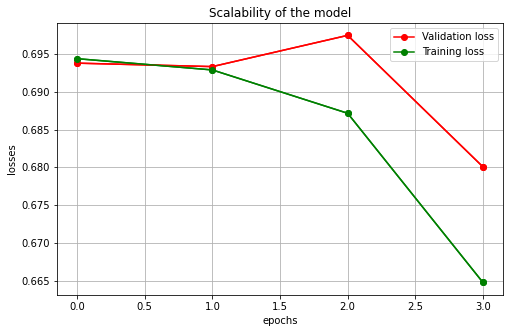


GRU model with hidden size :128 and number of layers: 2 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 50.18 | Valid accuracy: 51.17 %
Epoch: 1|| Train accuracy: 50.04 | Valid accuracy: 51.17 %
Epoch: 2|| Train accuracy: 60.80 | Valid accuracy: 68.90 %
Epoch: 3|| Train accuracy: 67.22 | Valid accuracy: 69.53 %

------------------- Scores ----------------------

Accuracy: 71.78 %
F1-score: 71.54 %
Recall-score: 72.10 %
Precision: 72.19 %

------------- Loss vs Epochs plot ---------------



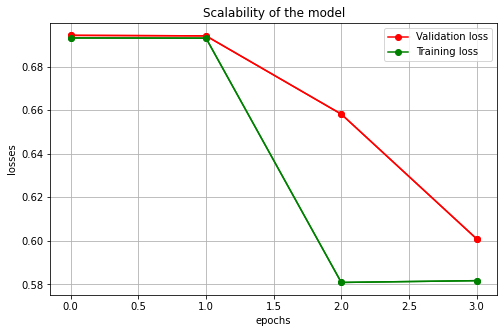


GRU model with hidden size :128 and number of layers: 3 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 50.99 | Valid accuracy: 51.17 %
Epoch: 1|| Train accuracy: 56.93 | Valid accuracy: 62.60 %
Epoch: 2|| Train accuracy: 64.38 | Valid accuracy: 67.33 %
Epoch: 3|| Train accuracy: 68.99 | Valid accuracy: 64.89 %

------------------- Scores ----------------------

Accuracy: 64.70 %
F1-score: 61.31 %
Recall-score: 65.65 %
Precision: 74.10 %

------------- Loss vs Epochs plot ---------------



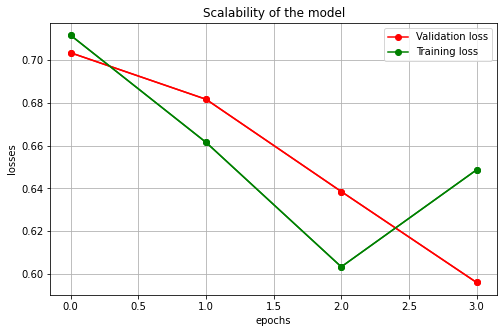


GRU model with hidden size :256 and number of layers: 1 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 50.22 | Valid accuracy: 50.54 %
Epoch: 1|| Train accuracy: 49.82 | Valid accuracy: 48.83 %
Epoch: 2|| Train accuracy: 50.10 | Valid accuracy: 51.17 %
Epoch: 3|| Train accuracy: 50.14 | Valid accuracy: 51.17 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------- Scores ----------------------

Accuracy: 51.42 %
F1-score: 33.85 %
Recall-score: 50.00 %
Precision: 25.71 %

------------- Loss vs Epochs plot ---------------



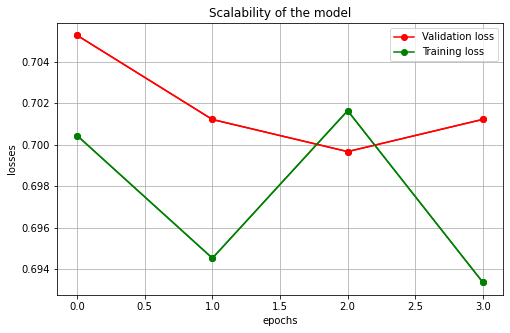


GRU model with hidden size :256 and number of layers: 2 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 53.14 | Valid accuracy: 51.46 %
Epoch: 1|| Train accuracy: 56.29 | Valid accuracy: 62.30 %
Epoch: 2|| Train accuracy: 59.31 | Valid accuracy: 61.47 %
Epoch: 3|| Train accuracy: 56.65 | Valid accuracy: 61.72 %

------------------- Scores ----------------------

Accuracy: 62.60 %
F1-score: 61.47 %
Recall-score: 62.22 %
Precision: 63.06 %

------------- Loss vs Epochs plot ---------------



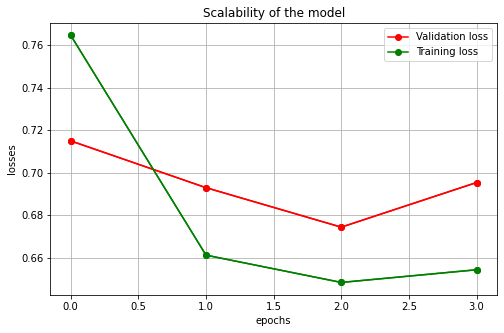


GRU model with hidden size :256 and number of layers: 3 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 56.74 | Valid accuracy: 65.87 %
Epoch: 1|| Train accuracy: 64.91 | Valid accuracy: 68.85 %
Epoch: 2|| Train accuracy: 68.58 | Valid accuracy: 72.36 %
Epoch: 3|| Train accuracy: 68.55 | Valid accuracy: 72.02 %

------------------- Scores ----------------------

Accuracy: 73.05 %
F1-score: 72.70 %
Recall-score: 73.15 %
Precision: 73.49 %

------------- Loss vs Epochs plot ---------------



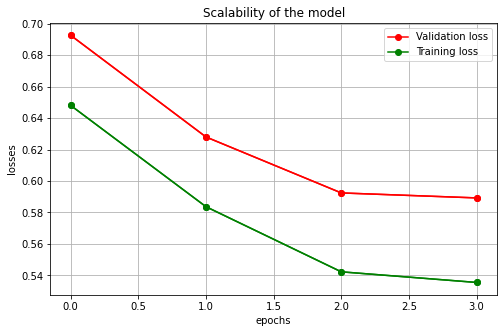


GRU model with hidden size :384 and number of layers: 1 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 54.79 | Valid accuracy: 58.64 %
Epoch: 1|| Train accuracy: 56.18 | Valid accuracy: 53.32 %
Epoch: 2|| Train accuracy: 56.36 | Valid accuracy: 55.42 %
Epoch: 3|| Train accuracy: 55.81 | Valid accuracy: 60.55 %

------------------- Scores ----------------------

Accuracy: 61.38 %
F1-score: 59.66 %
Recall-score: 61.04 %
Precision: 62.68 %

------------- Loss vs Epochs plot ---------------



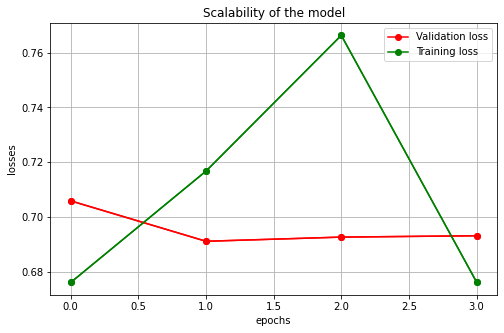


GRU model with hidden size :384 and number of layers: 2 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 53.71 | Valid accuracy: 56.93 %
Epoch: 1|| Train accuracy: 55.69 | Valid accuracy: 56.45 %
Epoch: 2|| Train accuracy: 55.72 | Valid accuracy: 57.67 %
Epoch: 3|| Train accuracy: 55.24 | Valid accuracy: 56.64 %

------------------- Scores ----------------------

Accuracy: 58.74 %
F1-score: 58.25 %
Recall-score: 58.90 %
Precision: 59.08 %

------------- Loss vs Epochs plot ---------------



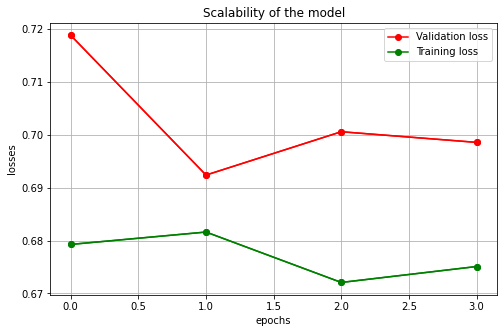


GRU model with hidden size :384 and number of layers: 3 
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 52.95 | Valid accuracy: 53.96 %
Epoch: 1|| Train accuracy: 53.38 | Valid accuracy: 48.88 %
Epoch: 2|| Train accuracy: 54.65 | Valid accuracy: 55.76 %
Epoch: 3|| Train accuracy: 53.71 | Valid accuracy: 56.93 %

------------------- Scores ----------------------

Accuracy: 59.57 %
F1-score: 59.21 %
Recall-score: 59.63 %
Precision: 59.61 %

------------- Loss vs Epochs plot ---------------



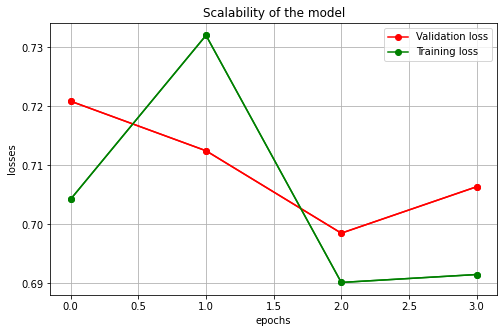

In [ ]:
# ============
input_size = 100       # length is 100, given in Field
output_size = 1     
bidirectional = True
cell_type = 'GRU'
embedding_dim = 25
# =============================
hidden_size = 256     # number of hidden neurons
num_layers =  1        # number of layers
dropout = 0.3
clip_param = 5
# =============================
num_epochs = 4
LR = 0.01
loss_function = nn.BCELoss()
# ==============================


net = GRUmodel_a(vocab.vectors,cell_type, input_size, output_size,embedding_dim, hidden_size, num_layers, bidirectional,dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters

print(f"\nGRU model")
print("-----------------------------------------------------------------\n")
valid_losses,train_losses = trainNet(net,train_iter,valid_iter,num_epochs,clip_param)
acc, f1,recall,precision = testNet(net, test_iter)
FinalDf.loc[len(FinalDf)] = [cell_type,num_layers,hidden_size,'3 layers',clip_param,dropout,acc,f1,recall,precision]
print("\n------------- Loss vs Epochs plot ---------------\n")
lossVSepoch(valid_losses,train_losses)


In [ ]:
FinalDf

,Cell type,Layers of stacked RNNs,Hidden size of layers,Skip connections,gradient clipping,Dropout prob,Accuracy,F1-score,Recall-score,Precision
0,GRU,3,256,-,10,0.3,0.671875,0.659983,0.670089,0.681228
1,GRU,3,256,-,3,0.3,0.685059,0.667182,0.680547,0.707130
2,GRU,3,256,-,5,0.3,0.674805,0.671108,0.675116,0.673978
3,GRU,3,256,-,7,0.3,0.496582,0.330419,0.500000,0.248291


# **Remarks**



*   For this model we used GloVe for the pre-process, with vector size 25. RMS was chosen as an optimizer and BCELoss as loss function, because of the binary classification.
*   For neural network architecture:

> * The first layer is an Embedding layer, which matches the input vectors to the vocabulary vectors.
> * The second layer is a Linear hidden layer,which accepts as input size, the size of the features multiplied by the size of the GloVe vectors. It uses ReLU as activation function.
>* The output layer is Linear with input dimension  200 and output 1 with sigmoid as activation function.









## References



*   https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f


